In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import os

import scipy
import networkx as nx

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

In [2]:
seed = 42
no_users = 16
lambda_logistic = 1e-3

In [3]:
def random_split(X, y, n, seed):
    """Equally split data between n agents"""
    rng = np.random.default_rng(seed)
    perm = rng.permutation(y.size)
    X_split = np.array_split(X[perm], n)  #np.stack to keep as a np array
    y_split = np.array_split(y[perm], n)
    return X_split, y_split

In [4]:
def loss(w, A, b, l2):
    z = b * np.dot(A, w)
    tmp = np.minimum(z, 0)
    loss = np.log((np.exp(tmp) + np.exp(tmp - z)) / np.exp(tmp))
    loss_sum = np.sum(loss) / len(b)
    reg = (np.linalg.norm(w) ** 2) * l2 / 2
    return loss_sum + reg

In [5]:
def gradient(w, A, b, l2):
    m = A.shape[0]
    z = b * np.dot(A, w)
    tmp0 = np.minimum(z, 0)
    tmp1 = np.exp(tmp0 - z) / ((np.exp(tmp0) + np.exp(tmp0 - z)))
    tmp2 = - tmp1 * b
    res = np.dot(A.T, tmp2) / m + l2 * w
    return res

In [6]:
def hessian(w, A, b, l2):
    Aw = A @ w
    activation = scipy.special.expit(Aw)
    weights = activation * (1-activation)
    A_weighted = np.multiply(A.T, weights)
    return A_weighted@A/A.shape[0] + l2*np.eye(A.shape[1])

In [7]:
def generate_graph(n, seed):
    """Generate a random connected graph"""
    while True:
        g = nx.generators.random_graphs.binomial_graph(n, 0.4, seed = seed) 
        # g = nx.random_geometric_graph(n, 0.4, seed = seed)
        #g = nx.grid_2d_graph(int(n/5), int(n/5))
        if nx.algorithms.components.is_connected(g):
            return g

In [8]:
def degrees(A):
    """Return the degrees of each node of a graph from its adjacency matrix"""
    return np.sum(A, axis=0).reshape(A.shape[0], 1)

In [9]:
def metropolis_weights(Adj):
    N = np.shape(Adj)[0]
    degree = degrees(Adj)
    W = np.zeros([N, N])
    for i in range(N):
        N_i = np.nonzero(Adj[i, :])[1]  # Fixed Neighbors
        for j in N_i:
            W[i, j] = 1/(1+np.max([degree[i], degree[j]]))
        W[i, i] = 1 - np.sum(W[i, :])
    return W

In [33]:
G = generate_graph(no_users, seed)

adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(G)
comm_matrix = metropolis_weights(adjacency_matrix)

print(G.number_of_edges())
print(G.number_of_nodes())
#nx.draw(G, with_labels=True, font_weight='bold')

54
16


In [59]:
X = np.load('X.npy')
y = np.load('y.npy').ravel()

num_feature = X.shape[1] #+ 1 #+1 for bias

In [60]:
print(y)

[-1. -1. -1. ...  1. -1. -1.]


In [61]:
X, y = random_split(X, y, no_users, seed)

theta = [np.zeros(num_feature) for _ in range(no_users)]
theta_new = [np.zeros(num_feature) for _ in range(no_users)]


d = [np.zeros(num_feature) for _ in range(no_users)] # direction
d_new = [np.zeros(num_feature) for _ in range(no_users)] # direction
grad_old = [np.zeros(num_feature) for _ in range(no_users)] # direction

lamd = [np.zeros(num_feature) for _ in range(no_users)] # dual variables

In [62]:
for i in range(no_users):
    grad = gradient(theta[i], X[i], y[i], lambda_logistic)
    d[i] = grad
    d_new[i] = d[i].copy()

In [63]:
# Optimal objective function, i.e., f(x*)
obj0 = 0.33458104150211826 # a1a dataset

In [66]:
n_iters = 200
alpha = 0.4

losses_dsgd = []
accuracies_dsgd = []
op_gap_dsgd = np.zeros(shape=[n_iters])
re_dsgd = np.zeros(shape=[n_iters])




for iter in range(n_iters):
    #alpha /= (iter + 1)
    for i in range(no_users):
        d[i] = d_new[i].copy()
        grad = gradient(theta[i], X[i], y[i], lambda_logistic)
        grad_old[i] = grad.copy()
        w_neighbors_sum = np.zeros(num_feature)
        w_neighbors_sum = np.add(w_neighbors_sum, comm_matrix[i,i]*theta[i])
        for j in G.neighbors(i):
            w_neighbors_sum = np.add(w_neighbors_sum, comm_matrix[i,j]*theta[j])
        
        theta_new[i] = w_neighbors_sum - alpha * d[i]
  
    for i in range(no_users):
        theta[i] = theta_new[i].copy()
        grad = gradient(theta[i], X[i], y[i], lambda_logistic)
    
        w_neighbors_sum = np.zeros(num_feature)
        w_neighbors_sum = np.add(w_neighbors_sum, comm_matrix[i,i]*d[i])
        for j in G.neighbors(i):
            w_neighbors_sum = np.add(w_neighbors_sum, comm_matrix[i,j]*d[j])
        
        d_new[i] = w_neighbors_sum + grad - grad_old[i]

    
    
    theta_avg = 1/no_users*sum(theta)
    
    loss_dsgd = np.mean([loss(theta_avg, X[i], y[i], lambda_logistic) for i in range(no_users)])
    losses_dsgd.append(loss_dsgd)
  
    op_gap_dsgd[iter] = np.abs(losses_dsgd[-1] - obj0)
    print(op_gap_dsgd[iter])

0.05573548022361435
0.05503954085339963
0.05436202690908448
0.05370215193812944
0.05305912773278515
0.05243225788063771
0.0518208408836468
0.05122426848969003
0.050641911403708495
0.05007324046189171
0.049517685927508326
0.048974789428402776
0.048444029397011035
0.04792501172218472
0.047417252691116574
0.04692041771875638
0.04643405141263851
0.04595787567468129
0.045491454364145256
0.04503456444487658
0.04458678012116285
0.04414793357316832
0.043717600312149274
0.04329566948522273
0.04288170845103606
0.04247566673874931
0.04207709337725091
0.04168600347691337
0.04130191653111703
0.04092492038691281
0.04055449243284609
0.04019080259178137
0.03983327184654856
0.03948216400515042
0.03913682720193795
0.03879763376066819
0.038463839919970266
0.03813594439387136
0.037813089347936535
0.037495921507532004
0.03718344305717253
0.03687647469422439
0.036573848294602584
0.03627658952383511
0.03598332440931046
0.035695320430310706
0.03541095609829753
0.03513178435200809
0.03485588733224393
0.0345851

# Optimality Gap

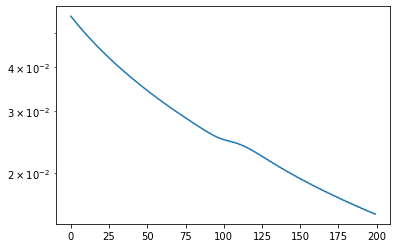

In [67]:
import matplotlib.pyplot as plt
plt.semilogy(op_gap_dsgd)
np.save('op_gap_gtdgd', op_gap_dsgd)